Using Transfer Learning and TensorFlow 2.0 to Classify Different Dog Breeds

In [2]:
# Importing Libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
from IPython.display import display, Image
import os 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

In [3]:
# Checking if GPU is available
print('GPU is available!') if tf.config.list_physical_devices('GPU') else 'not available'

GPU is available!


In [4]:
label_csv=pd.read_csv('drive/My Drive/Dog Vision/labels.csv')
print(label_csv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None


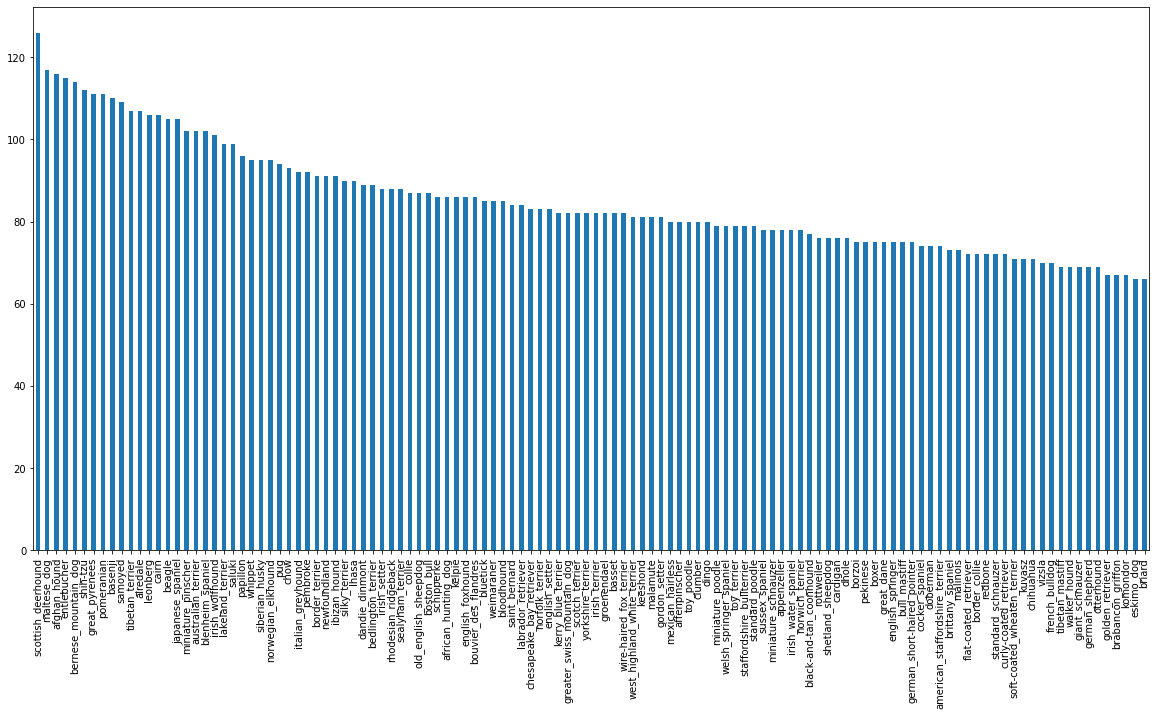

In [5]:
# Lets see how many pictures are there of each breed
label_csv['breed'].value_counts().plot.bar(figsize=(20,10))

In [6]:
# Saving each pictures path in an array
filenames= ['drive/My Drive/Dog Vision/train/'+ fname +'.jpg' for fname in label_csv['id']]

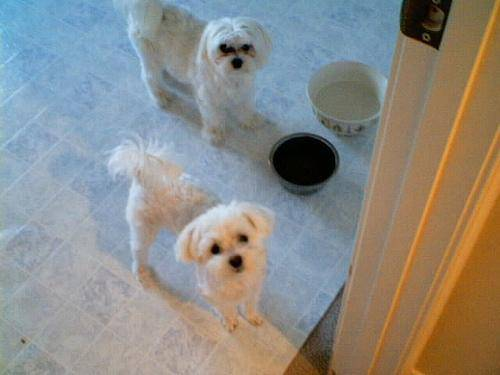

In [7]:
Image(filenames[90])

In [8]:
# Converting label column into NUmpy array
labels=label_csv['breed'].to_numpy()

# Checking if all files matches actual image files 
if len(os.listdir('drive/My Drive/Dog Vision/train/')) == len(filenames):
  print('File names match actual image files')
else:
  print('File names DO NOT match actual image files')
 
# Checking if label number is matches number of filenames
if len(filenames)==len(labels):
    print('Labels match actual file number')
else:
  print('Labels DO NOT match actual file number')

File names match actual image files
Labels match actual file number


In [9]:
# Storing unique breeds
unique_breeds= np.unique(labels)

# Turning each label into an array of booleans
boolean_labels = [label == unique_breeds for label in labels]
print(boolean_labels[:2])

[array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False]), array([False, False, False, False, False, False, False, Fal

In [10]:
# Splitting our data into train and validation sets
X = filenames
y = boolean_labels

# Since there are 10222 images, it will be computationally long for me to train model. Lets first experiment with 1000 images
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X[:1000],y[:1000],test_size=0.2,random_state=42)
len(X_train),len(y_train),len(X_val),len(y_val)

(800, 800, 200, 200)

In [11]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [12]:
IMG_SIZE=224

# Takes an image file path and turns into a Tensor
def process_image (image_path,img_size=IMG_SIZE):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image,channels=3)
  image = tf.image.convert_image_dtype(image,tf.float32)
  image = tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])
  return image

In [13]:
# Creating simple function, whcih return tuple(image,label)
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [43]:
BATCH_SIZE = 32
# Creating function to turn data into batches. Function will accomodate for all three sets(train,validation,test)

def create_data_batches(x,y=None,batch_size=BATCH_SIZE,val_data=False,test_data=False,train_data=False):
  if test_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  elif val_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  elif train_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data = data.shuffle(buffer_size=len(x))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

In [44]:
# creating training and validation data batches 
train_data = create_data_batches(X_train,y_train,train_data=True)
val_data = create_data_batches(X_val,y_val,val_data=True)
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [16]:
# Next step is to create model. I will use already pretrained model from TensorflowHub: mobilenet_v2_130_224
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3]
OUTPUT_SHAPE = len(unique_breeds)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

def create_model(input=INPUT_SHAPE,output=OUTPUT_SHAPE,model_url= MODEL_URL):
  model = tf.keras.Sequential([hub.KerasLayer(model_url),
                               tf.keras.layers.Dense(units=output,activation='softmax')])
  # Compiling model
  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
  model.build(input)
  return model


In [17]:
# Creating a model and check its details
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [18]:
# Creating Early Calling Callback to stop model when it starts overfitting and stops improving
%load_ext tensorboard
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
NUM_EPOCHS = 100

# Training the model
def train_model():
  model=create_model()
  model.fit(x=train_data,epochs=NUM_EPOCHS,validation_data=val_data,validation_freq=1,callbacks=[early_stopping])
  return model

model = train_model()

Epoch 1/100
25/25 [==============================] - 377s 14s/step - loss: 5.1553 - accuracy: 0.0462 - val_loss: 3.3567 - val_accuracy: 0.2650
Epoch 2/100
25/25 [==============================] - 4s 170ms/step - loss: 1.9657 - accuracy: 0.6056 - val_loss: 2.0869 - val_accuracy: 0.5200
Epoch 3/100
25/25 [==============================] - 4s 170ms/step - loss: 0.6121 - accuracy: 0.9416 - val_loss: 1.6073 - val_accuracy: 0.5850
Epoch 4/100
25/25 [==============================] - 4s 172ms/step - loss: 0.2568 - accuracy: 0.9854 - val_loss: 1.4275 - val_accuracy: 0.6400
Epoch 5/100
25/25 [==============================] - 4s 172ms/step - loss: 0.1569 - accuracy: 0.9988 - val_loss: 1.3626 - val_accuracy: 0.6350
Epoch 6/100
25/25 [==============================] - 4s 171ms/step - loss: 0.0998 - accuracy: 0.9990 - val_loss: 1.3125 - val_accuracy: 0.6500
Epoch 7/100
25/25 [==============================] - 4s 171ms/step - loss: 0.0755 - accuracy: 1.0000 - val_loss: 1.2879 - val_accuracy: 0.6500

In [60]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 113ms/step


array([[7.6178496e-04, 1.0321566e-04, 8.3413557e-04, ..., 2.4925140e-04,
        2.7956487e-05, 2.8075275e-03],
       [3.1723021e-04, 5.5470926e-05, 4.0090778e-03, ..., 2.8547982e-04,
        1.6666364e-03, 3.5516023e-05],
       [1.8993563e-06, 7.3736599e-05, 9.6660224e-06, ..., 7.7954042e-05,
        4.2684114e-06, 8.8806861e-05],
       ...,
       [1.4723673e-05, 1.0394912e-04, 2.2315820e-05, ..., 9.6517164e-05,
        1.0068697e-04, 1.0258407e-04],
       [1.4562078e-03, 9.7440177e-05, 5.9650905e-05, ..., 3.3694407e-05,
        1.9887873e-05, 2.8910604e-03],
       [1.7556720e-03, 5.0375951e-05, 8.8138063e-04, ..., 9.2489138e-04,
        2.2451898e-04, 1.8870889e-04]], dtype=float32)

In [61]:
# Lets unbatch a batched dataset
def unbatch_data(data):
  images=[]
  labels=[]

  for image,label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
    return images, labels

val_images,val_labels = unbatch_data(val_data)


In [62]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(pred_prob):
  return unique_breeds[np.argmax(pred_prob)]

In [63]:
def plot_pred_conf(n,prediction_prob,labels):
  pred_prob, true_label = prediction_prob[n], labels[n]
  pred_label = get_pred_label(pred_prob)
  pred_index = pred_prob.argsort()[-10:][::1]
  pred_values = pred_prob[pred_index]
  pred_lables = unique_breeds[pred_index]

  top_plot = plt.bar(np.arange (len(pred_label)),
                     pred_values,
                     color='grey')
  plt.xsticks(np.arange(len(pred_label)),
              labels=pred_label,
              rotation='vertical')
  
   # Change color of true label
  if np.isin(true_label, pred_label):
    top_plot[np.argmax(pred_label == true_label)].set_color("green")
  else:
    pass

In [68]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 109ms/step - loss: 1.2043 - accuracy: 0.6650


[1.2043163776397705, 0.6650000214576721]

In [83]:
# Training on the full data
full_data= create_data_batches(X,y,train_data=True)

In [77]:
full_model = create_model()

In [81]:
import keras
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [84]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 3165s 10s/step - loss: 2.3824 - accuracy: 0.4889
Epoch 2/100
320/320 [==============================] - 49s 154ms/step - loss: 0.4012 - accuracy: 0.8856
Epoch 3/100
320/320 [==============================] - 48s 150ms/step - loss: 0.2194 - accuracy: 0.9462
Epoch 4/100
320/320 [==============================] - 42s 132ms/step - loss: 0.1471 - accuracy: 0.9662
Epoch 5/100
320/320 [==============================] - 44s 136ms/step - loss: 0.1018 - accuracy: 0.9803
Epoch 6/100
320/320 [==============================] - 44s 138ms/step - loss: 0.0737 - accuracy: 0.9876
Epoch 7/100
320/320 [==============================] - 46s 143ms/step - loss: 0.0568 - accuracy: 0.9923
Epoch 8/100
320/320 [==============================] - 44s 137ms/step - loss: 0.0435 - accuracy: 0.9953
Epoch 9/100
320/320 [==============================] - 45s 142ms/step - loss: 0.0341 - accuracy: 0.9963
Epoch 10/100
320/320 [==============================] - 48s 150m

In [88]:
# Loading test images
test_filenames = ["drive/My Drive/Dog Vision/test/" + fname for fname in os.listdir("drive/My Drive/Dog Vision/test/")]

In [89]:
len(test_filenames)

10357

In [91]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

# Make predictions on test data batch using the loaded full model
test_predictions = full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 3459s 11s/step


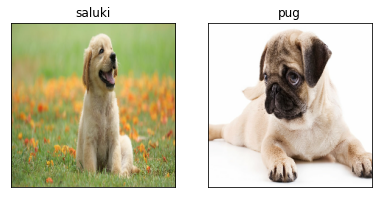

In [95]:
# Make prediction on customized image
custom_path = "drive/My Drive/Dog Vision/dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_preds = full_model.predict(custom_data)
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]

custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)


plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)